In [48]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt



In [49]:
# Establecer semillas aleatorias
rs = 42

np.random.seed(rs)
torch.manual_seed(rs)

In [50]:
# Definir el entorno personalizado
class CustomEnv(gym.Env):
    def __init__(self, delta_t, beta):
        super(CustomEnv, self).__init__()
        self.delta_t = delta_t
        self.beta = beta
        self.state = None
        self.done = False

        # Espacios de estado y acción
        self.observation_space = spaces.Box(low=-2.0, high=2.0, shape=(1,), dtype=np.float32)
        self.action_space = spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32)

        self.reset()

    def reset(self):
        self.state = np.array([-1.0], dtype=np.float32)
        self.done = False
        return self.state

    def step(self, action):
        s_t = self.state[0]
        a_t = action[0]

        # Gradiente del potencial
        grad_V = 4 * s_t * (s_t**2 - 1)

        # Ruido gaussiano
        eta = np.random.normal(0, np.sqrt(2 * self.delta_t / self.beta))

        # Dinámica de transición
        s_next = s_t + (-grad_V + np.sqrt(2 / self.beta) * a_t) * self.delta_t + eta

        # Limitar el estado al dominio [-2, 2]
        s_next = np.clip(s_next, -2.0, 2.0)

        self.state = np.array([s_next], dtype=np.float32)

        # Función de recompensa
        if s_next < 1.0:
            reward = -1 * self.delta_t - 0.5 * (a_t**2) * self.delta_t
            self.done = False
        else:
            reward = -0.0  # g(s) = 0
            self.done = True  # Episodio termina al alcanzar s >= 1

        return self.state, reward, self.done, {}

In [51]:
class PolicyNetwork(nn.Module):
    def __init__(self):
        super(PolicyNetwork, self).__init__()
        # Capas
        self.fc1 = nn.Linear(1, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 1)

        # Inicialización de pesos y sesgos
        self.init_weights()

    def init_weights(self):
        # Inicializar pesos y sesgos con U(-1e-2, 1e-2) y U(-1e-3, 1e-3)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                m.weight.data.uniform_(-1e-2, 1e-2)
                m.bias.data.uniform_(-1e-3, 1e-3)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

In [52]:
# Inicializar la política
policy = PolicyNetwork()

# Configurar el optimizador
optimizer = optim.Adam(policy.parameters(), lr=5e-3) # 5e-5


In [53]:
# Parámetros del entrenamiento
K = 1  # Tamaño del lote 1000
N = 5000  # Número de pasos de gradiente 10000
delta_t = 0.02  # Paso de tiempo .005
evaluate_every = 100  # Evaluar la política cada 100 actualizaciones
max_episode_length = N  # Máximo de pasos por episodio
beta = 1

# Listas para almacenar datos
rewards_per_evaluation = []
lengths_per_evaluation = []

env = CustomEnv(delta_t=delta_t, beta=beta)

for update in range(1, N + 1):
    # Almacenar gradientes estimados
    total_policy_gradient = [torch.zeros_like(param) for param in policy.parameters()]

    for k in range(K):
        # Simular una trayectoria
        states = []
        actions = []
        rewards = []
        etas = []
        grads_mu = []

        state = env.reset()
        done = False
        t = 0

        while not done and t < max_episode_length:
            s_t = torch.tensor(state)

            # Acción según la política determinística
            s_t_input = s_t.unsqueeze(0)  # Añadir dimensión batch
            a_t = policy(s_t_input).detach().numpy()[0]

            # Guardar estado y acción
            states.append(s_t)
            actions.append(a_t)

            # Obtener ruido eta
            eta = np.random.normal(0, 1)
            etas.append(eta)

            # Calcular gradiente de la política en s_t
            s_t_input.requires_grad_(True)
            a_t_tensor = policy(s_t_input)
            mu_grad = torch.autograd.grad(a_t_tensor, policy.parameters(), grad_outputs=torch.ones_like(a_t_tensor), retain_graph=True)
            grads_mu.append(mu_grad)

            # Interactuar con el entorno
            next_state, reward, done, _ = env.step(a_t)
            rewards.append(reward)

            state = next_state
            t += 1

        # Calcular G_0(τ)
        T = t
        sum_actions_squared = np.sum([0.5 * (a[0] ** 2) * delta_t for a in actions])
        G_0_tau = -T * delta_t - sum_actions_squared

        # Estimar el gradiente de la política para esta trayectoria
        for t_step in range(T):
            # Obtener términos necesarios
            mu_theta = actions[t_step][0]
            grad_mu_theta = grads_mu[t_step]
            eta_t1 = etas[t_step]

            # Calcular el coeficiente
            term1 = -delta_t * mu_theta
            term2 = G_0_tau * eta_t1
            coefficient = term1 + term2

            # Actualizar gradiente total
            for i, grad in enumerate(grad_mu_theta):
                total_policy_gradient[i] += coefficient * grad.detach()

    # Promediar el gradiente sobre K trayectorias
    average_policy_gradient = [g / K for g in total_policy_gradient]

    # Actualizar los parámetros de la política
    optimizer.zero_grad()
    # Aplicar los gradientes manualmente
    with torch.no_grad():
        for param, grad in zip(policy.parameters(), average_policy_gradient):
            param.grad = - grad
    optimizer.step()

    # Evaluar la política cada 100 actualizaciones
    if update % evaluate_every == 0:
        total_reward = 0
        total_length = 0
        num_episodes = 10  # Número de episodios para evaluación

        for _ in range(num_episodes):
            state = env.reset()
            done = False
            t = 0
            episode_reward = 0

            while not done and t < max_episode_length:
                s_t = torch.tensor(state)
                s_t_input = s_t.unsqueeze(0)
                a_t = policy(s_t_input).detach().numpy()[0]
                next_state, reward, done, _ = env.step(a_t)
                episode_reward += reward
                state = next_state
                t += 1

            total_reward += episode_reward
            total_length += t

        avg_reward = total_reward / num_episodes
        avg_length = total_length / num_episodes

        rewards_per_evaluation.append(avg_reward)
        lengths_per_evaluation.append(avg_length)

        print(f"Update {update}/{N}, Recompensa Promedio: {avg_reward:.4f}, Longitud Promedio: {avg_length:.2f}")



Update 100/5000, Recompensa Promedio: -2.5293, Longitud Promedio: 122.00
Update 200/5000, Recompensa Promedio: -3.5320, Longitud Promedio: 176.50
Update 300/5000, Recompensa Promedio: -5.1723, Longitud Promedio: 259.60
Update 400/5000, Recompensa Promedio: -2.7521, Longitud Promedio: 138.60
Update 500/5000, Recompensa Promedio: -3.3523, Longitud Promedio: 168.60
Update 600/5000, Recompensa Promedio: -4.9680, Longitud Promedio: 249.00
Update 700/5000, Recompensa Promedio: -3.8526, Longitud Promedio: 193.60
Update 800/5000, Recompensa Promedio: -2.2980, Longitud Promedio: 115.20
Update 900/5000, Recompensa Promedio: -2.6157, Longitud Promedio: 131.30
Update 1000/5000, Recompensa Promedio: -3.0241, Longitud Promedio: 152.10
Update 1100/5000, Recompensa Promedio: -4.2013, Longitud Promedio: 209.30
Update 1200/5000, Recompensa Promedio: -4.0022, Longitud Promedio: 195.40
Update 1300/5000, Recompensa Promedio: -2.9081, Longitud Promedio: 145.90
Update 1400/5000, Recompensa Promedio: -2.2005,

In [63]:
# # Gráfico de recompensa promedio por evaluación
# plt.figure(figsize=(12, 5))
# plt.plot(range(evaluate_every, N + 1, evaluate_every), rewards_per_evaluation)
# plt.xlabel('Actualizaciones')
# plt.ylabel('Recompensa Promedio')
# plt.title('beta = 4, K = 1, lambda = 5e-3, dt = .05', fontsize = 10)
# plt.suptitle('Recompensa Promedio por Evaluación', fontsize = 15)
# plt.grid(True)
# plt.show()

# # Gráfico de longitud promedio por evaluación
# plt.figure(figsize=(12, 5))
# plt.plot(range(evaluate_every, N + 1, evaluate_every), lengths_per_evaluation)
# plt.xlabel('Actualizaciones')
# plt.ylabel('Longitud Promedio del Episodio')
# plt.title('beta = 4, K = 1, lambda = 5e-3, dt = .05', fontsize = 10)
# plt.suptitle('Recorrido Promedio por Evaluación', fontsize = 15)
# plt.grid(True)
# plt.show()


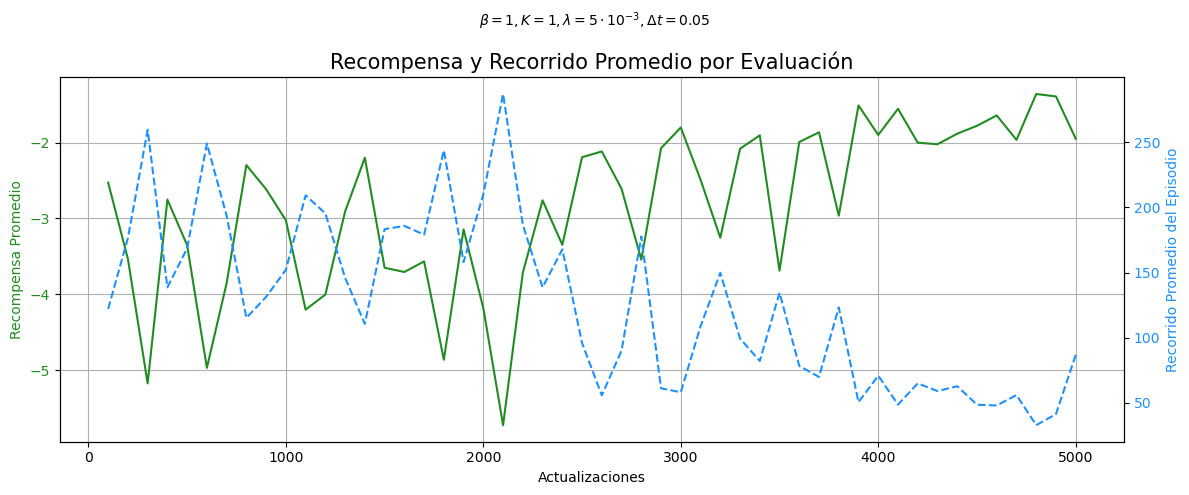

In [69]:

# Crear un gráfico combinado
fig, ax1 = plt.subplots(figsize=(12, 5))
fig.suptitle(r'$\beta = 1, K = 1, \lambda = 5 \cdot 10^{-3}, \Delta t = 0.05$', fontsize=10)

# Primer eje Y
ax1.plot(range(evaluate_every, N + 1, evaluate_every), rewards_per_evaluation, color='forestgreen', label='Recompensa Promedio')
ax1.set_xlabel('Actualizaciones')
ax1.set_ylabel('Recompensa Promedio', color='forestgreen')
ax1.tick_params(axis='y', labelcolor='forestgreen')
ax1.grid(True)

# Segundo eje Y
ax2 = ax1.twinx()
ax2.plot(range(evaluate_every, N + 1, evaluate_every), lengths_per_evaluation, color='dodgerblue', label='Longitud Promedio del Episodio', ls='--')
ax2.set_ylabel('Recorrido Promedio del Episodio', color='dodgerblue')
ax2.tick_params(axis='y', labelcolor='dodgerblue')

# Títulos
plt.title('Recompensa y Recorrido Promedio por Evaluación', fontsize=15)
fig.tight_layout()

plt.show()
